<a href="https://colab.research.google.com/github/rajmuchhala/idfy/blob/master/idfy_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# importing required modules 
from zipfile import ZipFile 
import pandas as pd
import string
from google.colab import files
import cv2
from sklearn.utils import shuffle
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.models import Model
from keras.layers import Input
import keras.backend as K
from keras.models import load_model

Using TensorFlow backend.


In [0]:
## Upload data on google colab
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [0]:
# specifying the zip file name 
file_name = "crnn_model (1).zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Done!') 

In [170]:
data = pd.read_csv("trainVal.csv") 
# Preview the first 5 lines of the loaded data 
data.head()

,track_id,image_path,lp,train
0,./crop_m1/I00000.png,./crop_m1/I00000.png,9B52145,0
1,./crop_m1/I00000.png,./crop_h1/I00000.png,9B52145,0
2,./crop_m1/I00001.png,./crop_m1/I00001.png,6B94558,0
3,./crop_m1/I00001.png,./crop_h1/I00001.png,6B94558,0
4,./crop_m1/I00002.png,./crop_m1/I00002.png,8B90164,0


In [0]:
##Randomly Shuffle the dataframe before splitting the data
data = shuffle(data)
data.reset_index(inplace=True, drop=True)

In [0]:
## Helper functions to preprocess output labels to indices and vice versa

# char_list:   'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
# total number of our output classes: len(char_list)
char_list = string.ascii_letters+string.digits
def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
        
    return dig_lst

# Reverse translation of numerical classes back to characters
def labels_to_text(labels):
    ret = []
    for c in labels:
      if(int(c)!=-1):
        ret.append(char_list[c])
    return "".join(ret)

In [0]:
##  Preprocess Training and Validation data and split them with 80/20 ratio
# lists for training dataset
training_img = []
training_txt = []
train_input_length = []
train_label_length = []
orig_txt = []

#lists for validation dataset
valid_img = []
valid_txt = []
valid_input_length = []
valid_label_length = []
valid_orig_txt = []

max_label_len = 0


for q in range(len(data)):
    # read input image and convert into gray scale image
    img = cv2.cvtColor(cv2.imread(data['image_path'][q]), cv2.COLOR_BGR2GRAY) 
    img = cv2.resize(img, (128, 32))
    img = np.expand_dims(img , axis = 2)
    # Normalize each image
    img = img/255.
    
    # get the text from the image
    txt = data['lp'][q]
    
    # compute maximum length of the text
    if len(txt) > max_label_len:
        max_label_len = len(txt)
        
        
    # split the 652 data into validation and training dataset as 20% and 80% respectively
    ## (Val = 0.2 * len(data) = 131, Train = len(data) - Val)
    if q<131:     
        valid_orig_txt.append(txt)   
        valid_label_length.append(len(txt))
        valid_input_length.append(31)
        valid_img.append(img)
        valid_txt.append(encode_to_labels(txt))
    else:
        orig_txt.append(txt)   
        train_label_length.append(len(txt))
        train_input_length.append(31)
        training_img.append(img)
        training_txt.append(encode_to_labels(txt)) 
    
    
# pad each output label to maximum text length

train_padded_txt = pad_sequences(training_txt, maxlen=max_label_len, padding='post', value = len(char_list))
valid_padded_txt = pad_sequences(valid_txt, maxlen=max_label_len, padding='post', value = len(char_list))

### Covert the lists to numpy arrays
training_img = np.array(training_img)
train_input_length = np.array(train_input_length)
train_label_length = np.array(train_label_length)

valid_img = np.array(valid_img)
valid_input_length = np.array(valid_input_length)
valid_label_length = np.array(valid_label_length)

In [173]:
#### Define the model 

##Input layer with dimensions(None,32,128,1)
inputs = layers.Input(shape=(32,128,1))
 
# convolution layer with kernel size (3,3)
conv_1 = layers.Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = layers.MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = layers.Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = layers.MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = layers.Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = layers.Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = layers.MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = layers.Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = layers.BatchNormalization()(conv_5)
 
conv_6 = layers.Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = layers.BatchNormalization()(conv_6)
pool_6 = layers.MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = layers.Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = layers.Lambda(lambda x: tf.keras.backend.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
lstm_1 = layers.LSTM(128, return_sequences=True, dropout = 0.2)
lstm_2 = layers.LSTM(128, return_sequences=True, dropout = 0.2)
blstm_1 = layers.Bidirectional(lstm_1)(squeezed)
blstm_2 = layers.Bidirectional(lstm_2)(blstm_1)
 
outputs = layers.Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

act_model.summary()

Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 32, 128, 1)]      0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 32, 128, 64)       640       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 16, 64, 64)        0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 16, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 8, 32, 128)        0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 8, 32, 256)        295168    
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 8, 32, 256)        590

In [0]:
## Define CTC loss function and the training model using CTC loss

labels = layers.Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
label_length = layers.Input(name='label_length', shape=[1], dtype='int64')
 
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
 
loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [0]:
## Compile the model
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam',metrics=['accuracy'])

##Load pre-trained model as new_model
new_model = load_model("crnn_model.h5")

##Load pre-trained weights and use them as initialization to re-train the model with our own data
act_model.set_weights(new_model.get_weights())


In [0]:
### Save the model after fine tuning on our own dataset
filepath="best_model.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [0]:
### Train the model
batch_size = 16
epochs = 20
history = model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length], y=np.zeros(len(training_img)), batch_size=batch_size, epochs = epochs, validation_data = ([valid_img, valid_padded_txt, valid_input_length, valid_label_length], [np.zeros(len(valid_img))]), verbose = 1, callbacks = callbacks_list)

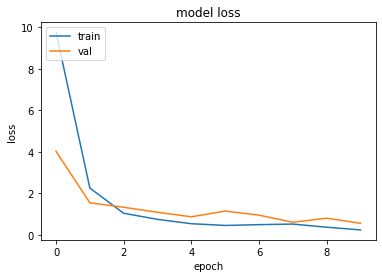

In [101]:
### Plot the training and validation loss versus epochs
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
#Visualize and predict outputs on few validation images
act_model.load_weights('best_model_b16_shuffle_adam.hdf5')
prediction = act_model.predict(valid_img[:5])
 
# use CTC decoder
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])
 

# see the results
i = 0
for x in out:
    print("original_text =  ", valid_orig_txt[i])
    print("predicted text = ", end = '')
    for p in x:  
        if int(p) != -1:
            print(char_list[int(p)], end = '')       
    print('\n')
    i+=1

In [0]:
### Calculate accuracy on validation(test) set using the best saved model
# predict outputs on few validation images
prediction = act_model.predict(valid_img)
 
# use CTC decoder
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])

##Predictions
preds = []
for p in out:
  preds.append(labels_to_text(p))

##Ground truths
orig = []
for i in range(len(valid_orig_txt)):
  orig.append(valid_orig_txt[i])
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print(accuracy_score(orig, preds))